<a href="https://colab.research.google.com/github/pedroafleite/instacart-market-basket-analysis/blob/main/instacart_4_modelling.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
%matplotlib inline

import seaborn as sns
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import itertools
import xgboost as xgb
import warnings
warnings.filterwarnings('ignore')

from google.colab import drive
drive.mount('/content/drive')

from sklearn.cluster import KMeans
from sklearn.cluster import DBSCAN
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestClassifier, GradientBoostingClassifier

from sklearn.model_selection import RandomizedSearchCV, cross_val_score, KFold
from sklearn.metrics import accuracy_score, confusion_matrix
from sklearn.utils import resample

df_customers = pd.read_csv('/content/drive/MyDrive/instacart/df_clustered.csv')
df_customers.head(10)

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


,Count_Orders,Average_Products_Order,Yogurt & Fruits,Fruits & Vegs,Packed Vegs & Fruits,Pretzels Lovers,Bread Lover,Customer_Category_km5,Customer_Category_km8,Customer_Category_dbsc5,Customer_Category_dbsc10
0,1.0,2.0,0.000000,0.000000,0.000000,0.500000,0.500000,4.0,6.0,0,0
1,1.0,11.0,0.090909,0.090909,0.181818,0.272727,0.363636,4.0,3.0,0,0
2,2.0,38.0,0.184211,0.276316,0.171053,0.171053,0.197368,0.0,2.0,1,0
3,1.0,5.0,0.000000,0.200000,0.200000,0.000000,0.600000,4.0,6.0,0,0
4,1.0,5.0,0.200000,0.200000,0.000000,0.200000,0.400000,4.0,6.0,0,0
5,1.0,21.0,0.142857,0.333333,0.190476,0.190476,0.142857,0.0,2.0,0,0
6,2.0,15.5,0.387097,0.161290,0.193548,0.129032,0.129032,0.0,3.0,1,0
7,1.0,9.0,0.444444,0.222222,0.000000,0.222222,0.111111,2.0,3.0,0,0
8,2.0,7.5,0.333333,0.400000,0.066667,0.200000,0.000000,1.0,3.0,1,0
9,1.0,19.0,0.526316,0.157895,0.157895,0.157895,0.000000,2.0,2.0,0,0


In [ ]:
df_customers.columns

Index(['Count_Orders', 'Average_Products_Order', 'Yogurt & Fruits',
       'Fruits & Vegs', 'Packed Vegs & Fruits', 'Pretzels Lovers',
       'Bread Lover', 'Customer_Category_km5', 'Customer_Category_km8',
       'Customer_Category_dbsc5', 'Customer_Category_dbsc10'],
      dtype='object')

Data will be split three-fold: a (1) training set, a(2) validation set and a (3) test set. Otherwise, in a two-fold split of the data, we would use up the test set for tuning up the parameters and would not have new data to actually evaluate the model, which would lead to overfitting (represented by a plainly wrong >0.99 accuracy score). This seems to be a very common mistake out there in the wild.

In [ ]:
# Sampling dataset
# Case of classification with kmeans (clusters=5)

# split data into train+validation set and test set
X_features =  df_customers[['Count_Orders', 'Average_Products_Order', 'Yogurt & Fruits',
       'Fruits & Vegs', 'Packed Vegs & Fruits', 'Pretzels Lovers',
       'Bread Lover']].to_numpy()
y_target_km5 = df_customers[['Customer_Category_km5']].to_numpy()

X_trainval_km5, X_test_km5, y_trainval_km5, y_test_km5 = train_test_split(X_features, y_target_km5, random_state=0)
X_train_km5, X_valid_km5, y_train_km5, y_valid_km5 = train_test_split(X_trainval_km5, y_trainval_km5, random_state=1)

In [ ]:
# Sampling dataset
# Case of classification with kmeans (clusters=8)

y_target_km8 = df_customers[['Customer_Category_km8']].to_numpy()

X_trainval_km8, X_test_km8, y_trainval_km8, y_test_km8 = train_test_split(X_features, y_target_km8, random_state=0)
X_train_km8, X_valid_km8, y_train_km8, y_valid_km8 = train_test_split(X_trainval_km8, y_trainval_km8, random_state=1)

In [ ]:
# Sampling dataset
# Case of classification with dbscan (min_samples=5 et eps=1.0)

y_target_dbsc5 = df_customers[['Customer_Category_dbsc5']].to_numpy()

X_trainval_dbsc5, X_test_dbsc5, y_trainval_dbsc5, y_test_dbsc5 = train_test_split(X_features, y_target_dbsc5, random_state=0)
X_train_dbsc5, X_valid_dbsc5, y_train_dbsc5, y_valid_dbsc5 = train_test_split(X_trainval_dbsc5, y_trainval_dbsc5, random_state=1)

In [ ]:
# Sampling dataset
# Case of classification with dbscan (min_samples=10 et eps=1.1)

y_target_dbsc10 = df_customers[['Customer_Category_dbsc10']].to_numpy()

X_trainval_dbsc10, X_test_dbsc10, y_trainval_dbsc10, y_test_dbsc10 = train_test_split(X_features, y_target_dbsc10, random_state=0)
X_train_dbsc10, X_valid_dbsc10, y_train_dbsc10, y_valid_dbsc10 = train_test_split(X_trainval_dbsc10, y_trainval_dbsc10, random_state=1)

# **Random Forest Classifier model**

Using:
- Validation data set split
- Cross-validation strategies:
  - k-fold: split in 5 folds. No need for stratifying.
  - Randomized search: In contrast to GridSearchCV, not all parameter values are tried out -- only a fixed number.


accuracy score : 0.9663


array([<matplotlib.axes._subplots.AxesSubplot object at 0x7f84e31d0f28>,
      dtype=object)

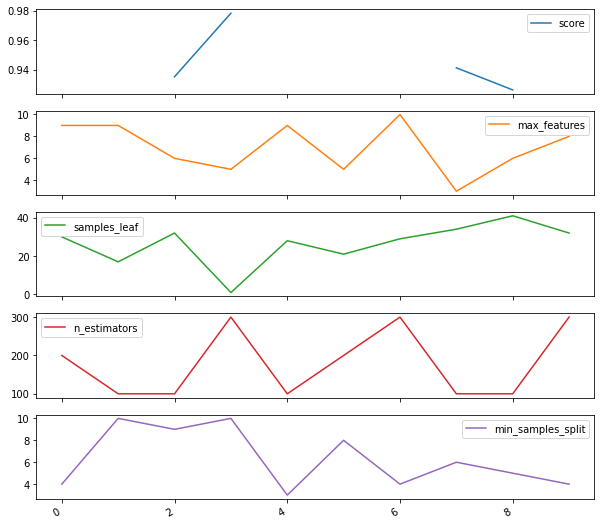

In [ ]:
# Classification using Random Forests algorithm
# (target variable: Customer_Category_km5)

rfc = RandomForestClassifier(random_state=40)
param_grid = {"max_features": np.linspace(1,10,10, dtype=int),
              "min_samples_leaf": np.linspace(1, 50, 50, dtype=int),
              "min_samples_split": np.linspace(2, 10, 9, dtype=int),
              "n_estimators":[100, 200, 300]}

# Choose cross-validation techniques
cv = KFold(n_splits=5, shuffle=True, random_state=40)

# Non_nested parameter search and scoring
rfc_rs_km5 = RandomizedSearchCV(rfc, param_grid, cv=cv, scoring='accuracy',
                            random_state=40, n_iter=10)
rfc_rs_km5.fit(X_train_km5, y_train_km5.ravel())

# Nested CV with parameter optimization (disregarding three-fold split of dataset)
nested_score = cross_val_score(rfc_rs_km5, X=X_valid_km5, y=y_valid_km5.ravel(), cv=cv)

# rebuild a model on the combined training and validation set and evaluate it on the test set
rfc_rs_km5_best = RandomForestClassifier(**rfc_rs_km5.best_params_)
rfc_rs_km5_best.fit(X_trainval_km5, y_trainval_km5)
best_score = cross_val_score(rfc_rs_km5, X=X_test_km5, y=y_test_km5.ravel(), cv=cv)

print("accuracy score : %.4f" % best_score.mean())
    
rfc_rs_df=pd.DataFrame(np.transpose([rfc_rs_km5.cv_results_['mean_test_score'],
                                     rfc_rs_km5.cv_results_['param_max_features'].data,
                                     rfc_rs_km5.cv_results_['param_min_samples_leaf'].data,
                                     rfc_rs_km5.cv_results_['param_n_estimators'].data,
                                     rfc_rs_km5.cv_results_['param_min_samples_split'].data]),
                           columns=['score', 'max_features', 'samples_leaf',
                                    'n_estimators', 'min_samples_split'])
rfc_rs_df.plot(subplots=True,figsize=(10, 10))

accuracy score : 0.9844


array([<matplotlib.axes._subplots.AxesSubplot object at 0x7f84e2afdb38>,
      dtype=object)

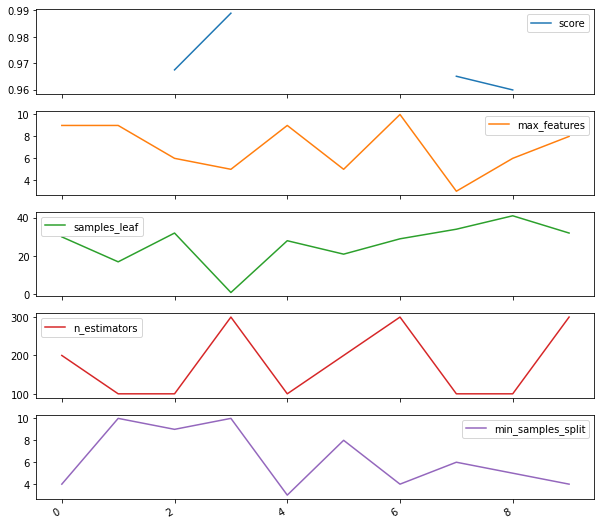

In [ ]:
# Classification using Random Forests algorithm
# (target variable: Customer_Category_km8)

rfc = RandomForestClassifier(random_state=40)
param_grid = {"max_features": np.linspace(1,10,10, dtype=int),
              "min_samples_leaf": np.linspace(1, 50, 50, dtype=int),
              "min_samples_split": np.linspace(2, 10, 9, dtype=int),
              "n_estimators":[100, 200, 300]}

# Choose cross-validation techniques
cv = KFold(n_splits=5, shuffle=True, random_state=40)

# Non_nested parameter search and scoring
rfc_rs_km8 = RandomizedSearchCV(rfc, param_grid, cv=cv, scoring='accuracy',
                            random_state=40, n_iter=10)
rfc_rs_km8.fit(X_train_km8, y_train_km8.ravel())

# Nested CV with parameter optimization (disregarding three-fold split of dataset)
nested_score = cross_val_score(rfc_rs_km8, X=X_valid_km8, y=y_valid_km8.ravel(), cv=cv)

# rebuild a model on the combined training and validation set and evaluate it on the test set
rfc_rs_km8_best = RandomForestClassifier(**rfc_rs_km8.best_params_)
rfc_rs_km8_best.fit(X_trainval_km8, y_trainval_km8)
best_score = cross_val_score(rfc_rs_km8, X=X_test_km8, y=y_test_km8.ravel(), cv=cv)

print("accuracy score : %.4f" % best_score.mean())
    
rfc_rs_df=pd.DataFrame(np.transpose([rfc_rs_km8.cv_results_['mean_test_score'],
                                     rfc_rs_km8.cv_results_['param_max_features'].data,
                                     rfc_rs_km8.cv_results_['param_min_samples_leaf'].data,
                                     rfc_rs_km8.cv_results_['param_n_estimators'].data,
                                     rfc_rs_km8.cv_results_['param_min_samples_split'].data]),
                           columns=['score', 'max_features', 'samples_leaf',
                                    'n_estimators', 'min_samples_split'])
rfc_rs_df.plot(subplots=True,figsize=(10, 10))

accuracy score : 0.9942


array([<matplotlib.axes._subplots.AxesSubplot object at 0x7f84e29418d0>,
      dtype=object)

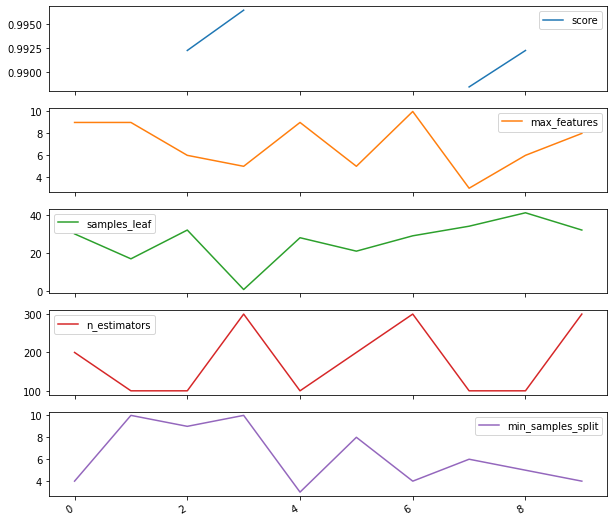

In [ ]:
# Classification using Random Forests algorithm
# (target variable: Customer_Category_dbsc5)

rfc = RandomForestClassifier(random_state=40)
param_grid = {"max_features": np.linspace(1,10,10, dtype=int),
              "min_samples_leaf": np.linspace(1, 50, 50, dtype=int),
              "min_samples_split": np.linspace(2, 10, 9, dtype=int),
              "n_estimators":[100, 200, 300]}

# Choose cross-validation techniques
cv = KFold(n_splits=5, shuffle=True, random_state=40)

# Non_nested parameter search and scoring
rfc_rs_dbsc5 = RandomizedSearchCV(rfc, param_grid, cv=cv, scoring='accuracy',
                            random_state=40, n_iter=10)
rfc_rs_dbsc5.fit(X_train_dbsc5, y_train_dbsc5.ravel())

# Nested CV with parameter optimization (disregarding three-fold split of dataset)
nested_score = cross_val_score(rfc_rs_dbsc5, X=X_valid_dbsc5, y=y_valid_dbsc5.ravel(), cv=cv)

# rebuild a model on the combined training and validation set and evaluate it on the test set
rfc_rs_dbsc5_best = RandomForestClassifier(**rfc_rs_dbsc5.best_params_)
rfc_rs_dbsc5_best.fit(X_trainval_dbsc5, y_trainval_dbsc5)
best_score = cross_val_score(rfc_rs_dbsc5, X=X_test_dbsc5, y=y_test_dbsc5.ravel(), cv=cv)

print("accuracy score : %.4f" % best_score.mean())
    
rfc_rs_df=pd.DataFrame(np.transpose([rfc_rs_dbsc5.cv_results_['mean_test_score'],
                                     rfc_rs_dbsc5.cv_results_['param_max_features'].data,
                                     rfc_rs_dbsc5.cv_results_['param_min_samples_leaf'].data,
                                     rfc_rs_dbsc5.cv_results_['param_n_estimators'].data,
                                     rfc_rs_dbsc5.cv_results_['param_min_samples_split'].data]),
                           columns=['score', 'max_features', 'samples_leaf',
                                    'n_estimators', 'min_samples_split'])
rfc_rs_df.plot(subplots=True,figsize=(10, 10))

accuracy score : 0.9952


array([<matplotlib.axes._subplots.AxesSubplot object at 0x7f84e2776550>,
      dtype=object)

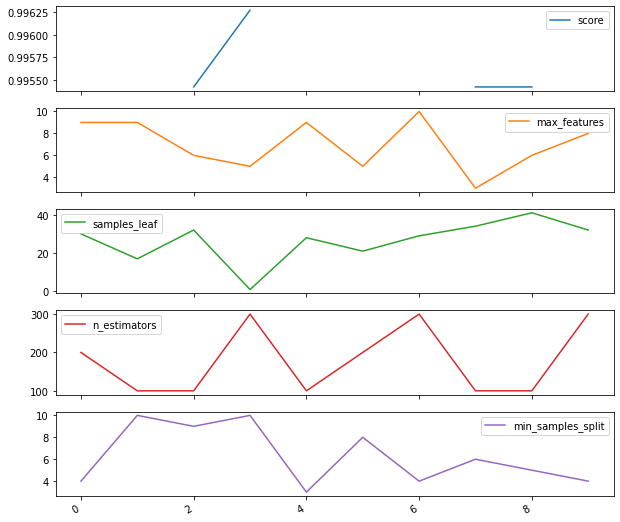

In [ ]:
# Classification using Random Forests algorithm
# (target variable: Customer_Category_dbsc10)

rfc = RandomForestClassifier(random_state=40)
param_grid = {"max_features": np.linspace(1,10,10, dtype=int),
              "min_samples_leaf": np.linspace(1, 50, 50, dtype=int),
              "min_samples_split": np.linspace(2, 10, 9, dtype=int),
              "n_estimators":[100, 200, 300]}

# Choose cross-validation techniques
cv = KFold(n_splits=5, shuffle=True, random_state=40)

# Non_nested parameter search and scoring
rfc_rs_dbsc10 = RandomizedSearchCV(rfc, param_grid, cv=cv, scoring='accuracy',
                            random_state=40, n_iter=10)
rfc_rs_dbsc10.fit(X_train_dbsc10, y_train_dbsc10.ravel())

# Nested CV with parameter optimization (disregarding three-fold split of dataset)
nested_score = cross_val_score(rfc_rs_dbsc10, X=X_valid_dbsc10, y=y_valid_dbsc10.ravel(), cv=cv)

# rebuild a model on the combined training and validation set and evaluate it on the test set
rfc_rs_dbsc10_best = RandomForestClassifier(**rfc_rs_dbsc10.best_params_)
rfc_rs_dbsc10_best.fit(X_trainval_dbsc10, y_trainval_dbsc10)
best_score = cross_val_score(rfc_rs_dbsc10, X=X_test_dbsc10, y=y_test_dbsc10.ravel(), cv=cv)

print("accuracy score : %.4f" % best_score.mean())
    
rfc_rs_df=pd.DataFrame(np.transpose([rfc_rs_dbsc10.cv_results_['mean_test_score'],
                                     rfc_rs_dbsc10.cv_results_['param_max_features'].data,
                                     rfc_rs_dbsc10.cv_results_['param_min_samples_leaf'].data,
                                     rfc_rs_dbsc10.cv_results_['param_n_estimators'].data,
                                     rfc_rs_dbsc10.cv_results_['param_min_samples_split'].data]),
                           columns=['score', 'max_features', 'samples_leaf',
                                    'n_estimators', 'min_samples_split'])
rfc_rs_df.plot(subplots=True,figsize=(10, 10))

In [ ]:
def plot_confusion_matrix(cm, classes, title, cmap=plt.cm.Reds):
    ''' This function prints and plots a normalized confusion matrix.
  
  Parameters:
      
      cm : the confusion matix 
      classes (list): the labels to diplay on the graph
      title (string): the title of the confusion matrix plot
      
  '''

    cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
    plt.figure(figsize=(8,8))
    plt.imshow(cm, interpolation='nearest', cmap=cmap)
    plt.title(title, bbox={"pad":3, 'alpha': 0.5,"facecolor":'red'}, size=18)
    plt.colorbar()
    tick_marks = np.arange(len(classes))
    plt.xticks(tick_marks, classes, rotation=45)
    plt.yticks(tick_marks, classes)

    fmt = '.2f'
    thresh = cm.max() / 2.
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        plt.text(j, i, format(cm[i, j], fmt),
                 horizontalalignment="center",
                 color="white" if cm[i, j] > thresh else "black")

    plt.ylabel('True label')
    plt.xlabel('Predicted label')
    plt.tight_layout()

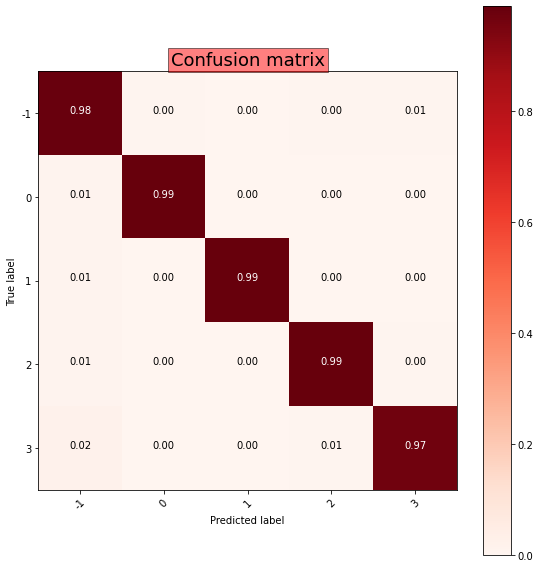

In [ ]:
# Confusion matrix of the Random Forests classifier model
# (target variable: Customer_Category_km8)

y_pred_km5 = rfc_rs_km5.predict(X_test_km5)
cnf_matrix = confusion_matrix(y_test_km5, y_pred_km5)
plot_confusion_matrix(cnf_matrix, classes=[i for i in range(-1, 4)],
                      title='Confusion matrix')

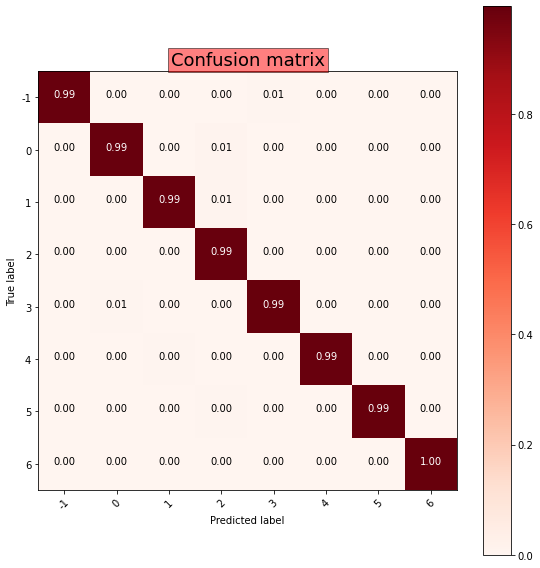

In [ ]:
# Confusion matrix of the Random Forests classifier model
# (target variable: Customer_Category_km8)

y_pred_km8 = rfc_rs_km8.predict(X_test_km8)
cnf_matrix = confusion_matrix(y_test_km8, y_pred_km8)
plot_confusion_matrix(cnf_matrix, classes=[i for i in range(-1, 7)],
                      title='Confusion matrix')

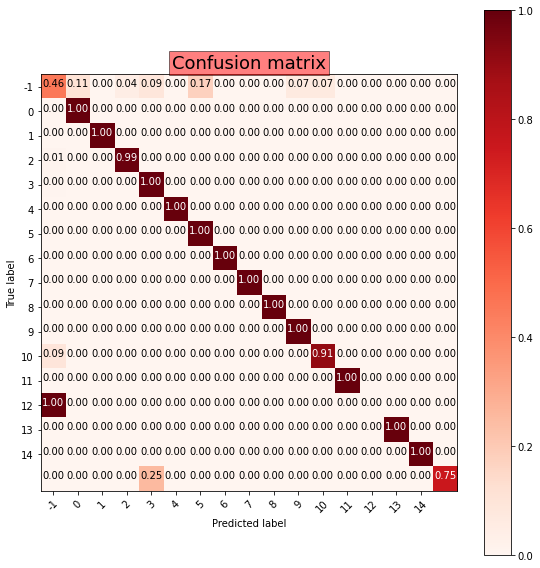

In [ ]:
# Confusion matrix of the Random Forests classifier model
# (target variable: Customer_Category_dbsc5)

y_pred_dbsc5 = rfc_rs_dbsc5.predict(X_test_dbsc5)
cnf_matrix = confusion_matrix(y_test_dbsc5, y_pred_dbsc5)
plot_confusion_matrix(cnf_matrix, classes=[i for i in range(-1, 15)],
                      title='Confusion matrix')

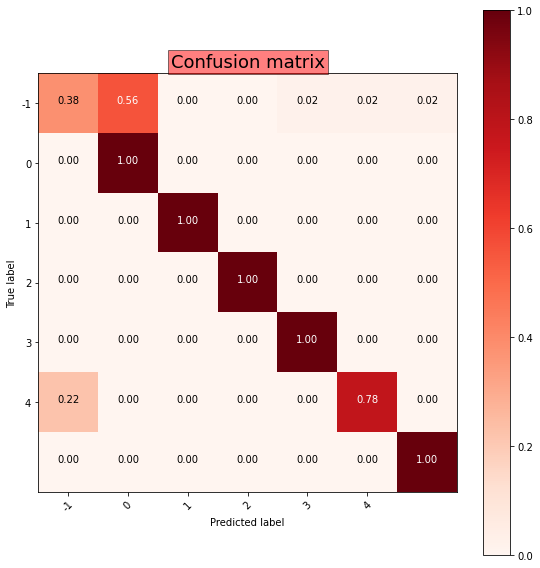

In [ ]:
# Confusion matrix of the Random Forests classifier model
# (target variable: Customer_Category_dbsc10)

y_pred_dbsc10 = rfc_rs_dbsc10.predict(X_test_dbsc10)
cnf_matrix = confusion_matrix(y_test_dbsc10, y_pred_dbsc10)
plot_confusion_matrix(cnf_matrix, classes=[i for i in range(-1, 5)],
                      title='Confusion matrix')

# XGBoosting models

accuracy score : 0.9801


array([<matplotlib.axes._subplots.AxesSubplot object at 0x7f84e00bb780>,
      dtype=object)

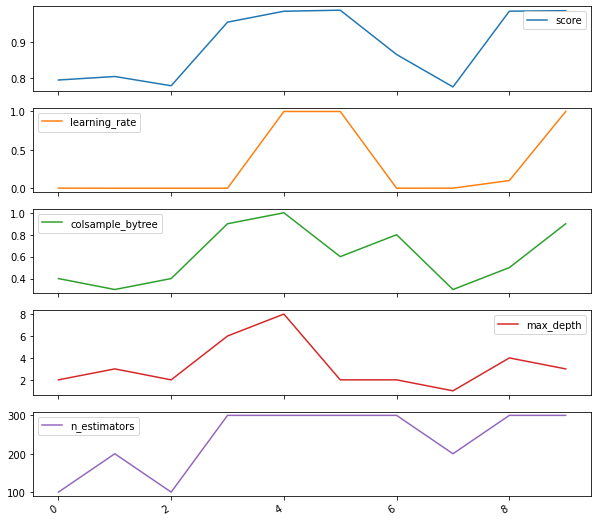

In [ ]:
# Classification using XGBoosting model
# (target variable: Customer_Category_km5)

xgb_model = xgb.XGBClassifier()
param_grid = {'learning_rate': np.logspace(-5, 0, 6),
              'n_estimators': np.linspace(100, 300, 3,dtype = int),
              "colsample_bytree": np.linspace(0.3, 1, 8),
              "max_depth" : np.linspace(1, 10, 9, dtype=int)}

# Choose cross-validation techniques
cv = KFold(n_splits=5, shuffle=True, random_state=40)

# Non_nested parameter search and scoring
xgb_rs_km5 = RandomizedSearchCV(xgb_model, param_grid, cv=cv, scoring='accuracy',
                            random_state=40, n_iter=10)
xgb_rs_km5.fit(X_train_km5, y_train_km5.ravel())

# Nested CV with parameter optimization (disregarding three-fold split of dataset)
nested_score = cross_val_score(xgb_rs_km5, X=X_valid_km5, y=y_valid_km5.ravel(), cv=cv)

# rebuild a model on the combined training and validation set and evaluate it on the test set
xgb_rs_km5_best = xgb.XGBClassifier(**xgb_rs_km5.best_params_)
xgb_rs_km5_best.fit(X_trainval_km5, y_trainval_km5)
best_score = cross_val_score(xgb_rs_km5, X=X_test_km5, y=y_test_km5.ravel(), cv=cv)

print("accuracy score : %.4f" % best_score.mean())
    
xgb_rs_df=pd.DataFrame(np.transpose([xgb_rs_km5.cv_results_['mean_test_score'],
                                     xgb_rs_km5.cv_results_['param_learning_rate'].data,
                                     xgb_rs_km5.cv_results_['param_colsample_bytree'].data,
                                     xgb_rs_km5.cv_results_['param_max_depth'].data,
                                     xgb_rs_km5.cv_results_['param_n_estimators'].data]),
                           columns=['score', 'learning_rate', 'colsample_bytree',
                                    'max_depth', 'n_estimators'])
xgb_rs_df.plot(subplots=True,figsize=(10, 10))

accuracy score : 0.9874


array([<matplotlib.axes._subplots.AxesSubplot object at 0x7f84dfee62e8>,
      dtype=object)

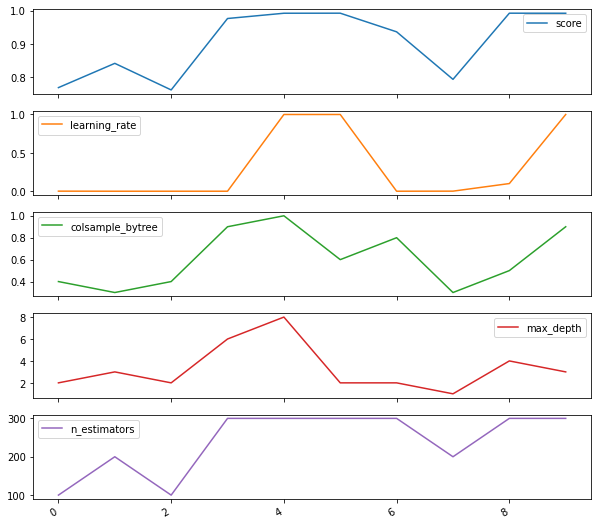

In [ ]:
# Classification using XGBoosting model
# (target variable: Customer_Category_km8)

xgb_model = xgb.XGBClassifier()
param_grid = {'learning_rate': np.logspace(-5, 0, 6),
              'n_estimators': np.linspace(100, 300, 3,dtype = int),
              "colsample_bytree": np.linspace(0.3, 1, 8),
              "max_depth" : np.linspace(1, 10, 9, dtype=int)}

# Choose cross-validation techniques
cv = KFold(n_splits=5, shuffle=True, random_state=40)

# Non_nested parameter search and scoring
xgb_rs_km8 = RandomizedSearchCV(xgb_model, param_grid, cv=cv, scoring='accuracy',
                            random_state=40, n_iter=10)
xgb_rs_km8.fit(X_train_km8, y_train_km8.ravel())

# Nested CV with parameter optimization (disregarding three-fold split of dataset)
nested_score = cross_val_score(xgb_rs_km8, X=X_valid_km8, y=y_valid_km8.ravel(), cv=cv)

# rebuild a model on the combined training and validation set and evaluate it on the test set
xgb_rs_km8_best = xgb.XGBClassifier(**xgb_rs_km8.best_params_)
xgb_rs_km8_best.fit(X_trainval_km8, y_trainval_km8)
best_score = cross_val_score(xgb_rs_km8, X=X_test_km8, y=y_test_km8.ravel(), cv=cv)

print("accuracy score : %.4f" % best_score.mean())
    
xgb_rs_df=pd.DataFrame(np.transpose([xgb_rs_km8.cv_results_['mean_test_score'],
                                     xgb_rs_km8.cv_results_['param_learning_rate'].data,
                                     xgb_rs_km8.cv_results_['param_colsample_bytree'].data,
                                     xgb_rs_km8.cv_results_['param_max_depth'].data,
                                     xgb_rs_km8.cv_results_['param_n_estimators'].data]),
                           columns=['score', 'learning_rate', 'colsample_bytree',
                                    'max_depth', 'n_estimators'])
xgb_rs_df.plot(subplots=True,figsize=(10, 10))

accuracy score : 0.9942


array([<matplotlib.axes._subplots.AxesSubplot object at 0x7f84dff32a20>,
      dtype=object)

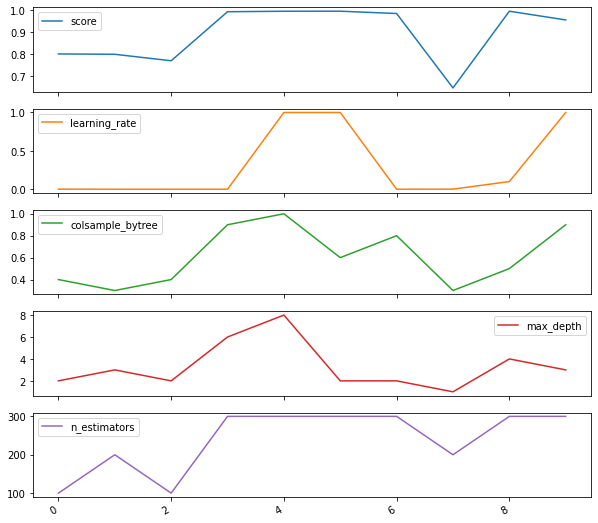

In [ ]:
# Classification using XGBoosting model
# (target variable: Customer_Category_dbsc5)

xgb_model = xgb.XGBClassifier()
param_grid = {'learning_rate': np.logspace(-5, 0, 6),
              'n_estimators': np.linspace(100, 300, 3,dtype = int),
              "colsample_bytree": np.linspace(0.3, 1, 8),
              "max_depth" : np.linspace(1, 10, 9, dtype=int)}

# Choose cross-validation techniques
cv = KFold(n_splits=5, shuffle=True, random_state=40)

# Non_nested parameter search and scoring
xgb_rs_dbsc5 = RandomizedSearchCV(xgb_model, param_grid, cv=cv, scoring='accuracy',
                            random_state=40, n_iter=10)
xgb_rs_dbsc5.fit(X_train_dbsc5, y_train_dbsc5.ravel())

# Nested CV with parameter optimization (disregarding three-fold split of dataset)
nested_score = cross_val_score(xgb_rs_dbsc5, X=X_valid_dbsc5, y=y_valid_dbsc5.ravel(), cv=cv)

# rebuild a model on the combined training and validation set and evaluate it on the test set
xgb_rs_dbsc5_best = xgb.XGBClassifier(**xgb_rs_dbsc5.best_params_)
xgb_rs_dbsc5_best.fit(X_trainval_dbsc5, y_trainval_dbsc5)
best_score = cross_val_score(xgb_rs_dbsc5, X=X_test_dbsc5, y=y_test_dbsc5.ravel(), cv=cv)

print("accuracy score : %.4f" % best_score.mean())
    
xgb_rs_df=pd.DataFrame(np.transpose([xgb_rs_dbsc5.cv_results_['mean_test_score'],
                                     xgb_rs_dbsc5.cv_results_['param_learning_rate'].data,
                                     xgb_rs_dbsc5.cv_results_['param_colsample_bytree'].data,
                                     xgb_rs_dbsc5.cv_results_['param_max_depth'].data,
                                     xgb_rs_dbsc5.cv_results_['param_n_estimators'].data]),
                           columns=['score', 'learning_rate', 'colsample_bytree',
                                    'max_depth', 'n_estimators'])
xgb_rs_df.plot(subplots=True,figsize=(10, 10))

accuracy score : 0.9949


array([<matplotlib.axes._subplots.AxesSubplot object at 0x7f84dfb4f240>,
      dtype=object)

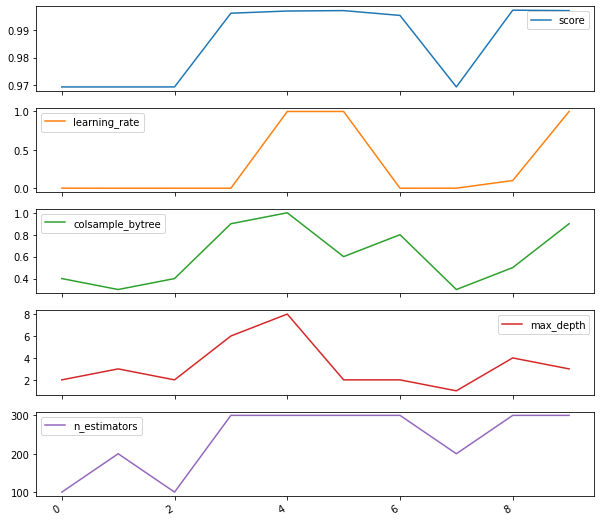

In [ ]:
# Classification using XGBoosting model
# (target variable: Customer_Category_dbsc10)

xgb_model = xgb.XGBClassifier()
param_grid = {'learning_rate': np.logspace(-5, 0, 6),
              'n_estimators': np.linspace(100, 300, 3,dtype = int),
              "colsample_bytree": np.linspace(0.3, 1, 8),
              "max_depth" : np.linspace(1, 10, 9, dtype=int)}

# Choose cross-validation techniques
cv = KFold(n_splits=5, shuffle=True, random_state=40)

# Non_nested parameter search and scoring
xgb_rs_dbsc10 = RandomizedSearchCV(xgb_model, param_grid, cv=cv, scoring='accuracy',
                            random_state=40, n_iter=10)
xgb_rs_dbsc10.fit(X_train_dbsc10, y_train_dbsc10.ravel())

# Nested CV with parameter optimization (disregarding three-fold split of dataset)
nested_score = cross_val_score(xgb_rs_dbsc10, X=X_valid_dbsc10, y=y_valid_dbsc10.ravel(), cv=cv)

# rebuild a model on the combined training and validation set and evaluate it on the test set
xgb_rs_dbsc10_best = xgb.XGBClassifier(**xgb_rs_dbsc10.best_params_)
xgb_rs_dbsc10_best.fit(X_trainval_dbsc10, y_trainval_dbsc10)
best_score = cross_val_score(xgb_rs_dbsc10, X=X_test_dbsc10, y=y_test_dbsc10.ravel(), cv=cv)

print("accuracy score : %.4f" % best_score.mean())
    
xgb_rs_df=pd.DataFrame(np.transpose([xgb_rs_dbsc10.cv_results_['mean_test_score'],
                                     xgb_rs_dbsc10.cv_results_['param_learning_rate'].data,
                                     xgb_rs_dbsc10.cv_results_['param_colsample_bytree'].data,
                                     xgb_rs_dbsc10.cv_results_['param_max_depth'].data,
                                     xgb_rs_dbsc10.cv_results_['param_n_estimators'].data]),
                           columns=['score', 'learning_rate', 'colsample_bytree',
                                    'max_depth', 'n_estimators'])
xgb_rs_df.plot(subplots=True,figsize=(10, 10))

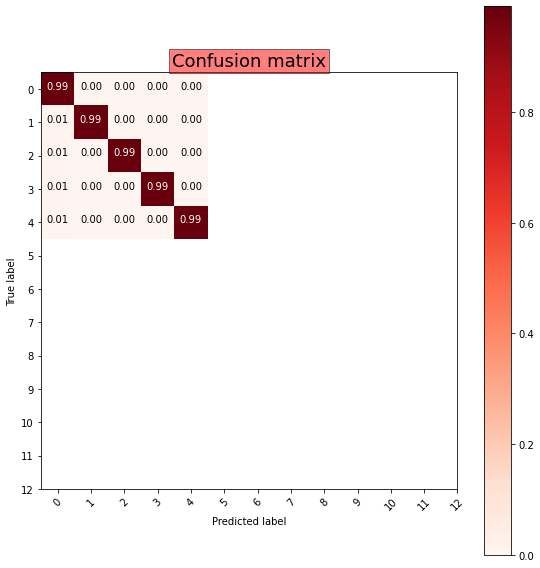

In [ ]:
# Confusion matrix of the XGBoosting model
# (target variable: Customer_Category_km5)

y_pred = xgb_rs_km5.predict(X_test_km5)
cnf_matrix = confusion_matrix(y_test_km5, y_pred)
plot_confusion_matrix(cnf_matrix, classes=[i for i in range(13)],
                      title='Confusion matrix')

# Medium-quality predicitions (60%) for the cluster n°9 (containg only 33 elements)
# No accurate predictions for the cluster n°8 (containing only 7 elements)

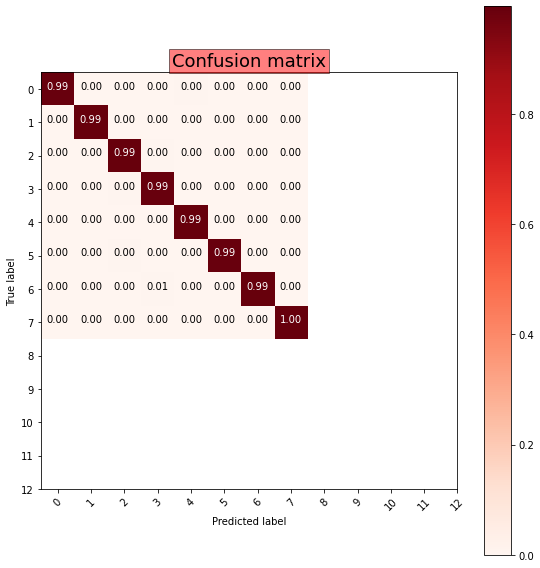

In [ ]:
# Confusion matrix of the XGBoosting model
# (target variable: Customer_Category_km8)

y_pred = xgb_rs_km8.predict(X_test_km8)
cnf_matrix = confusion_matrix(y_test_km8, y_pred)
plot_confusion_matrix(cnf_matrix, classes=[i for i in range(13)],
                      title='Confusion matrix')

# Medium-quality predicitions (60%) for the cluster n°9 (containg only 33 elements)
# No accurate predictions for the cluster n°8 (containing only 7 elements)

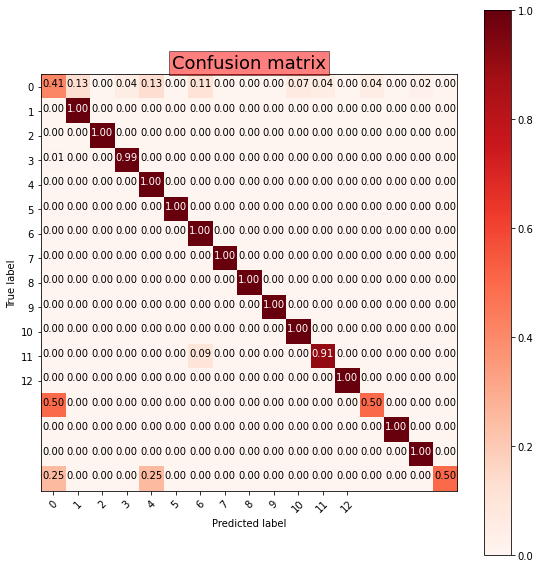

In [ ]:
# Confusion matrix of the XGBoosting model
# (target variable: Customer_Category_dbsc5)

y_pred = xgb_rs_dbsc5.predict(X_test_dbsc5)
cnf_matrix = confusion_matrix(y_test_dbsc5, y_pred)
plot_confusion_matrix(cnf_matrix, classes=[i for i in range(13)],
                      title='Confusion matrix')

# Medium-quality predicitions (60%) for the cluster n°9 (containg only 33 elements)
# No accurate predictions for the cluster n°8 (containing only 7 elements)

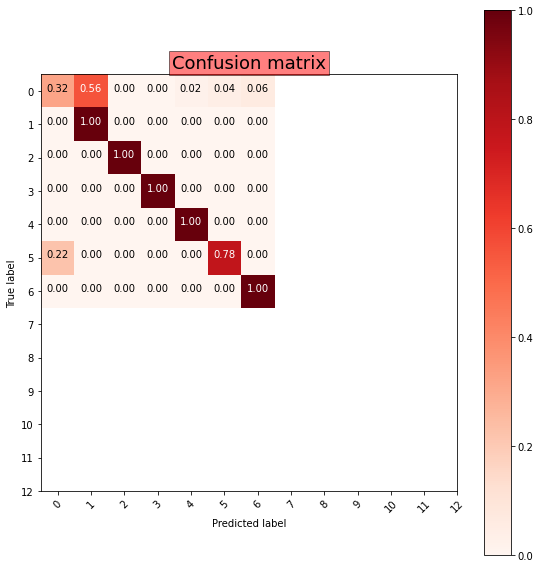

In [ ]:
# Confusion matrix of the XGBoosting model
# (target variable: Customer_Category_dbsc10)

y_pred = xgb_rs_dbsc10.predict(X_test_dbsc10)
cnf_matrix = confusion_matrix(y_test_dbsc10, y_pred)
plot_confusion_matrix(cnf_matrix, classes=[i for i in range(13)],
                      title='Confusion matrix')

# Medium-quality predicitions (60%) for the cluster n°9 (containg only 33 elements)
# No accurate predictions for the cluster n°8 (containing only 7 elements)

In [ ]:
print(df_customers['Count_Orders'].loc[df_customers['Count_Orders']<5.0].count())
df_customers['Count_Orders'].loc[df_customers['Count_Orders']>=5.0].count()

34732


589

# **Evaluation**

In [ ]:
# Evaluation of the Gradient Boosting model (target variable: Customer_Category_km8)
# depending on the number of transactions (important (> 5) and the others)

X_count_high = (df_customers.loc[df_customers['Count_Orders']>=5.0])[['Count_Orders', 'Average_Products_Order', 'Yogurt & Fruits',
       'Fruits & Vegs', 'Packed Vegs & Fruits', 'Pretzels Lovers', 'Bread Lover']].to_numpy()
X_count_low = (df_customers.loc[df_customers['Count_Orders']<5.0])[['Count_Orders', 'Average_Products_Order', 'Yogurt & Fruits',
       'Fruits & Vegs', 'Packed Vegs & Fruits', 'Pretzels Lovers', 'Bread Lover']].to_numpy()

y_count_high = (df_customers.loc[df_customers['Count_Orders']>=5.0])['Customer_Category_km8'].to_numpy()
y_count_low = (df_customers.loc[df_customers['Count_Orders']<5.0])['Customer_Category_km8'].to_numpy()

# Validation set for the consumers who have made more than 5 purchases on the website
X_train, X_validation_high, y_train, y_validation_high = train_test_split(
    X_count_high, y_count_high, test_size=0.5,train_size=0.5, random_state=40)

# Validation set for the consumers who have made less than 5 purchases on the website
X_train, X_validation_low, y_train, y_validation_low = train_test_split(
    X_count_low, y_count_low, test_size=0.3,train_size=0.7, random_state=40)

y_pred_low = xgb_rs_km8_best.predict(X_validation_low)
accuracy_low = accuracy_score(y_validation_low, y_pred_low)

y_pred_high = xgb_rs_km8_best.predict(X_validation_high)
accuracy_high = accuracy_score(y_validation_high, y_pred_high)

print("accuracy score (consumers who have made less than 5 purchases on the website): %.4f" % accuracy_low)
print("accuracy score (consumers who have made more than 5 purchases on the website): %.4f" % accuracy_high)

accuracy score (consumers who have made less than 5 purchases on the website): 0.9984
accuracy score (consumers who have made more than 5 purchases on the website): 0.9932


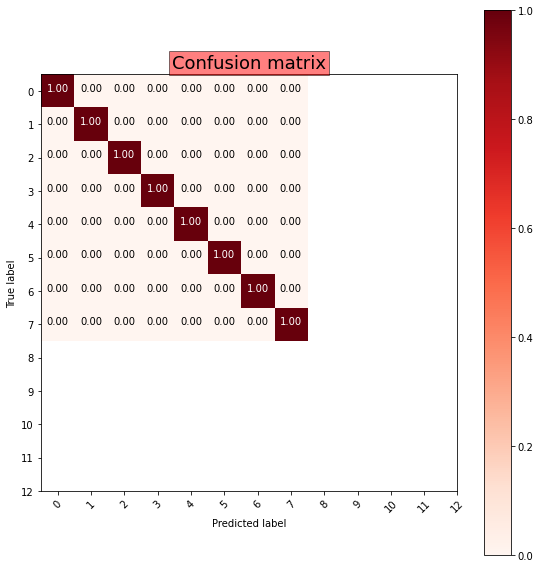

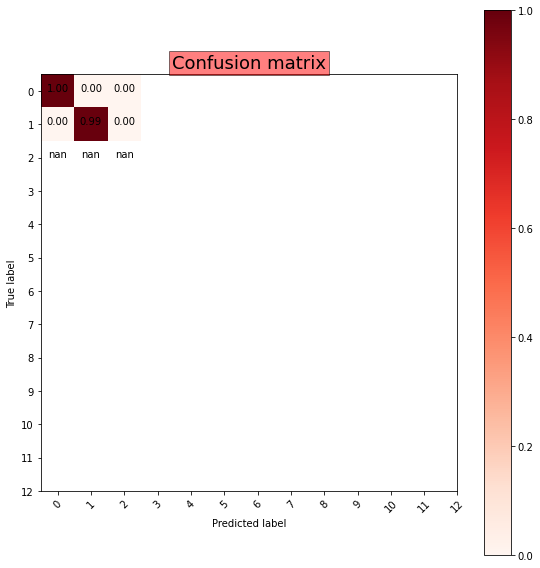

In [ ]:
# Confusion matrix
cnf_matrix = confusion_matrix(y_validation_low, y_pred_low)
plot_confusion_matrix(cnf_matrix, classes=[i for i in range(13)],
                      title='Confusion matrix')

cnf_matrix = confusion_matrix(y_validation_high, y_pred_high)
plot_confusion_matrix(cnf_matrix, classes=[i for i in range(13)],
                      title='Confusion matrix')

In [ ]:
# Evaluation of the Gradient Boosting model (target variable: Customer_Category_dbsc10)
# depending on the number of transactions (important (> 5) and the others)

X_count_high = (df_customers.loc[df_customers['Count_Orders']>=5.0])[['Count_Orders', 'Average_Products_Order', 'Yogurt & Fruits',
       'Fruits & Vegs', 'Packed Vegs & Fruits', 'Pretzels Lovers', 'Bread Lover']].to_numpy()
X_count_low = (df_customers.loc[df_customers['Count_Orders']<5.0])[['Count_Orders', 'Average_Products_Order', 'Yogurt & Fruits',
       'Fruits & Vegs', 'Packed Vegs & Fruits', 'Pretzels Lovers', 'Bread Lover']].to_numpy()

y_count_high = (df_customers.loc[df_customers['Count_Orders']>=5.0])['Customer_Category_dbsc10'].to_numpy()
y_count_low = (df_customers.loc[df_customers['Count_Orders']<5.0])['Customer_Category_dbsc10'].to_numpy()

# Validation set for the consumers who have made more than 5 purchases on the website
X_train, X_validation_high, y_train, y_validation_high = train_test_split(
    X_count_high, y_count_high, test_size=0.5,train_size=0.5, random_state=40)

# Validation set for the consumers who have made less than 5 purchases on the website
X_train, X_validation_low, y_train, y_validation_low = train_test_split(
    X_count_low, y_count_low, test_size=0.3,train_size=0.7, random_state=40)

y_pred_low = xgb_rs_dbsc10_best.predict(X_validation_low)
accuracy_low = accuracy_score(y_validation_low, y_pred_low)

y_pred_high = xgb_rs_dbsc10_best.predict(X_validation_high)
accuracy_high = accuracy_score(y_validation_high, y_pred_high)

print("accuracy score (consumers who have made less than 5 purchases on the website): %.4f" % accuracy_low)
print("accuracy score (consumers who have made more than 5 purchases on the website): %.4f" % accuracy_high)

accuracy score (consumers who have made less than 5 purchases on the website): 0.9995
accuracy score (consumers who have made more than 5 purchases on the website): 0.9627


In [ ]:
# Evaluation of the 2 best models on the test set

y_pred_km8 = xgb_rs_km8_best.predict(X_test_km8)
accuracy_km8 = accuracy_score(y_test_km8, y_pred_km8)

y_pred_dbsc10 = xgb_rs_dbsc10_best.predict(X_test_dbsc10)
accuracy_dbsc10 = accuracy_score(y_test_dbsc10, y_pred_dbsc10)

print("accuracy score of the Gradient Boosting model (target variable:"
      "Customer_Category_km8) with a hard upsampling on the test set: %.4f" % accuracy_km8)
print("accuracy score of the Gradient Boosting model (target variable:"
      "Customer_Category_dbsc10) with a hard upsampling on the test set: %.4f" % accuracy_dbsc10)

accuracy score of the Gradient Boosting model (target variable:Customer_Category_km8) with a hard upsampling on the test set: 0.9943
accuracy score of the Gradient Boosting model (target variable:Customer_Category_dbsc10) with a hard upsampling on the test set: 0.9963


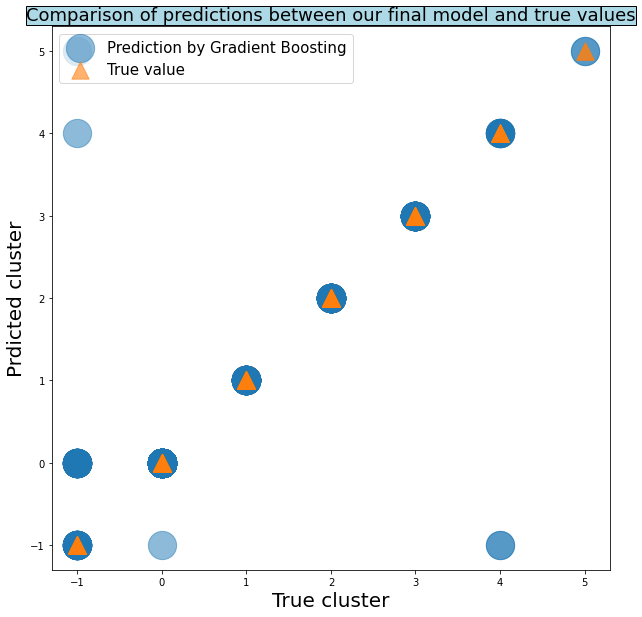

In [ ]:
# Display the classification prediction on the test set for the model:
# Gradient Boosting (target variable:Customer_Category_dbsc10 ) with a hard upsampling

plt.figure(figsize=(10,10))

plt.title("Comparison of predictions between our final model and true values", 
          bbox={"pad":0.5, "facecolor":'lightblue'}, size=18)
plt.scatter(y_test_dbsc10, y_pred_dbsc10, s=800, alpha=0.5)
plt.scatter(y_test_dbsc10, y_test_dbsc10, marker='^', s=300, alpha=0.6)
plt.ylabel("Prdicted cluster", size=20)
plt.xlabel("True cluster", size=20)
plt.legend(["Prediction by Gradient Boosting","True value"], fontsize=15,
           loc='upper left')
plt.show()